In [2]:
from dotenv import load_dotenv 
load_dotenv()

import os, sys
from pathlib import Path
src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

%load_ext autoreload
%autoreload 2 

In [3]:
from utils.custom_message_text import show_prompt
from core.prompts.PromptManager import PromptManager
from core.prompts.PromptType import PromptType
prompt_manager = PromptManager()
prompt = prompt_manager.get_prompt(PromptType.SYSTEM_RESEARCH, messages=[], date="")
show_prompt(prompt)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  <역할>                                                                                                         │
│  당신은 사용자의 입력 주제에 대해 리서치를 수행하는 연구 보조원 입니다.                                         │
│  오늘 날짜는 입니다. 오늘 날짜를 기반으로 리서치를 수행합니다.                                                  │
│                                                                                                                 │
│  <사고 절차>                                                                                                    │
│  인간 연구자처럼 사고 하며 다음 절차를 따르세요:                                                                │
│  1. 질문을 주의 깊게 읽고 핵심 요구를 파악                                                                      │
│  2. 먼저 포괄적인 검색을 수행                                                                                   │
│  3. 각 검색 후 결과 평가 ("충분한가?", "무엇이 부족한가?")                                                      │
│  4. 부족하면 더 구체적인 검색 수행                                                                              │
│  5. 충분하면 리서치 종료                                                                                        │
│                                                                                                                 │
│  <사용 가능한 도구들>                                                                                           │
│  - **rag_search**: RAG 검색용                                                                                   │
│  - **think_tool**: 결과 분석 및 다음 단계 계획용                                                                │
│  각 검색 후 반드시 **think_tool**을 사용해 결과를 평가하세요.                                                   │
│                                                                                                                 │
│  <행동 규칙>                                                                                                    │
│  - 인간 연구자처럼 사고하며, 근거를 명확히 기술하세요.                                                          │
│  - 각 검색 후 반드시 주어진 주제에 대해 도구를 활용해 자료를 수집하고 분석하세요.                               │
│  - 너무 많은 검색 반복을 피하고, 판단 근거를 명확히 기술하세요.                                                 │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  - 간단한 쿼리: 최대 3회 검색                                                                                   │
│  - 복잡한 쿼리: 최대 5회 검색                                                                                   │
│  - 5회 이상에도 답을 찾지 못하면 종료                                                                           │
│                                                                                                                 │
│  <작업>                                                                                                         │
│  주어진 주제에 대해 툴을 활용해 자료를 수집하고 분석하세요.                                                     │
│  툴은 순차 또는 병렬로 호출할 수 있으며, 루프 형태로 리서치를 수행합니다.                                       │
│                                                                                                                 │
│  <사고 과정을 보여주세요>                                                                                       │
│  각 검색 후 think_tool로 반성적 질문 수행:                                                                      │
│  - 무엇을 찾았는가?                                                                                             │
│  - 무엇이 부족한가?                                                                                             │
│  - 충분한가?                                                                                                    │

In [ ]:
# %%writefile research_state.py

from typing import TypedDict, Annotated, Sequence, List, Literal
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
import operator

class ResearcherState(TypedDict):
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

class Summary(BaseModel):
    summary: str = Field(description="웹페이지 콘텐츠의 간결한 요약")
    key_excerpts:str = Field(description="콘텐츠에서 발췌한 중요한 인용문과 핵심 구절")

In [2]:
%%writefile research_agent.py
from typing_extensions import TypedDict, Annotated, Sequence, List,Literal
from langchain.chat_models import init_chat_model
from langchain_core.messages import filter_messages
from agent.research.research_state import ResearcherState, ResearcherOutputState
from utils.helper import get_today_str
from tools.think_tool import think_tool
from tools.retriever_tool import axriv_search
from core.prompts.PromptManager import PromptManager
from core.prompts.PromptType import PromptType
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from langgraph.graph import StateGraph, START, END

tools = [think_tool, axriv_search]
tools_by_name = {tool.name: tool for tool in tools}
model = init_chat_model(model="gpt-5.1-2025-11-13", model_provider="openai")
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="gpt-4.1-mini")
compress_model = init_chat_model(model="gpt-4.1")

prompt_manager = PromptManager()


def llm_call(state: ResearcherState) -> ResearcherState:
    system_prompt = prompt_manager.get_prompt(
        PromptType.SYSTEM_RESEARCH, date=get_today_str()
    )
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=system_prompt)] + state["researcher_messages"]
            )
        ]
    }


def tool_node(state: ResearcherState) -> ResearcherState:
    tool_calls = state["researcher_messages"][-1].tool_calls

    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))

    tool_outputs = [
        ToolMessage(
            content=observation, name=tool_call["name"], tool_call_id=tool_call["id"]
        )
        for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"researcher_messages": tool_outputs}


def compress_research(state: ResearcherState) -> ResearcherOutputState:
    system_prompt = prompt_manager.get_prompt(
        PromptType.SYSTEM_RESEARCH_COMPRESS_SYSTEM, date=get_today_str()
    )
    human_prompt = prompt_manager.get_prompt(
        PromptType.SYSTEM_RESEARCH_COMPRESS_HUMAN,
        research_topic=state["research_topic"],
    )
    messages = (
        [SystemMessage(content=system_prompt)]
        + state.get("researcher_messages", [])
        + [HumanMessage(content=human_prompt)]
    )
    response = compress_model.invoke(messages)

    filter_mgs = filter_messages(state["researcher_messages"], include_type=["tool", "ai"])
    raw_notes = [str(m.content) for m in filter_mgs]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)],
    }


def should_continue(
    state: ResearcherState,
) -> Literal["tool_node", "compress_research"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return "compress_research"


graph_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)
graph_builder.add_node("llm_call", llm_call)
graph_builder.add_node("tool_node", tool_node)
graph_builder.add_node("compress_research", compress_research)

graph_builder.add_edge(START, "llm_call")
graph_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {"tool_node": "tool_node", "compress_research": "compress_research"},
)
graph_builder.add_edge("tool_node", "llm_call")
graph_builder.add_edge("compress_research", END)

graph = graph_builder.compile()

Overwriting research_agent.py


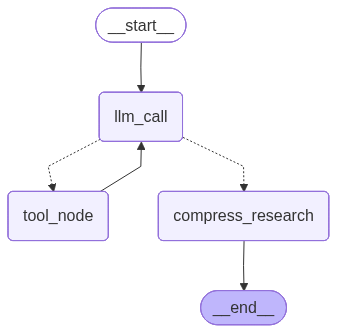